In [1]:
from initial_data_wrangling import load_dni_data, load_load_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def total_seconds(timedelta):
    return timedelta.astype("timedelta64[s]").astype(float)

In [20]:
def interp(load, dni):
    load_t = total_seconds(load['time'] - load['time'][0]) / 60  # min
    dni_t = total_seconds(dni['time'] - dni['time'][0]) / 60  # min
    dni_t -= 7 * 60  # UTC -> PDT

    dnis = np.interp(load_t, dni_t, np.mean(dni['dnis'], axis=1))
    load_power = load["power"]
    solar_pu = dnis / 1000
    return load_t, load_power, solar_pu

In [21]:
def filter_days(start_day, num_days, load_t, load, solar_pu):
    min_per_day = 60 * 24
    t_start = start_day * min_per_day
    t_end = t_start + num_days * min_per_day  # 1day * 60 min/hr * 24hr/day
    times = np.logical_and(load_t <= t_end, load_t >= t_start)
    load_t = load_t[times]
    load = load[times]
    solar_pu = solar_pu[times]
    return load_t, load, solar_pu

In [24]:
start_day = 0
num_days = 1
load = load_load_data()
dni = load_dni_data()
load_t, load, solar_pu = interp(load, dni)
load_t, load, solar_pu = filter_days(start_day, num_days, load_t, load, solar_pu)

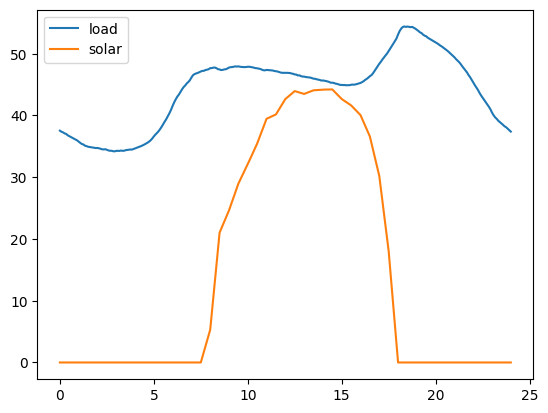

In [25]:
plt.figure()
plt.plot(load_t / 60 - start_day * 24, load, label='load')
plt.plot(load_t / 60 - start_day * 24, solar_pu * 50, label='solar')
plt.legend()

In [26]:
MWh_per_MW = 4
solar_power_installed = 100 # MW
geothermal_installed = 40  # MW
battery_capacity = 400 * MWh_per_MW  # MWh
design = np.array([
    solar_power_installed,
    geothermal_installed,
    battery_capacity
])

# For ratio 1 MW : 4 hr
# Cost for 4 MWh
# 350k/MW + 4 * 300k/MWh / 4 MWh/MW
cost_pu = np.array([
    1250,   # k/MW
    3500,   # k/MW
    (350 / MWh_per_MW + 300)  # k/MWh
])

In [27]:
def capital_cost(design, cost_pu):
    """
    Price in 1,000s of USD of capital expenditures of design.
    
    Arguments:
        design: 3-vector of [solar capacity (MW), geothermal capacity (MW), battery capacity (MWh)]
        cost_pu: 3-vector of cost per MW (MWh) of each of the preceding
    """
    return np.sum(design * cost_pu)

In [28]:
total_capital_cost = capital_cost(design, cost_pu) / 1000  # million USD
print(f"Capital cost of design: {total_capital_cost} million USD")

Capital cost of design: 885.0 million USD


In [29]:
# def control_constraints(design, solar_pu):
#     """Constraints of controllable generation as a function of time.
    
#     Arguments: 
#         design: [solar, geothermal, battery]
    
#     Returns:
#         Ut: (T, R^X) -> R^(U x 2): function from time index, state variable
#             to a matrix of control constraints with the first column representing
#             the minimum value for each control u_i, and the second column
#             representing the maximum.
#     """
#     P = design[0]
#     E = design[2]
#     def U_t(t, x):
#         return np.array([
#             [0, P * solar_pu[t]],
#             [x - E, x]
#         ])
#     return U_t
    

In [191]:
class SampleSpace:
    def __init__(self, design, n_u, delta_t, T_max, w, solar_pu):
        self.design = design
        self.n_u = n_u
        self.N_x, self.N_u = self.find_dims(n_u, T_max, delta_t)
        self.N_T = w.shape[0]
        self.delta_t = delta_t
        self.T_max = T_max
        self.w = w
        self.solar_pu = solar_pu
        self.J = np.arange(0, self.N_u)
        self.X, self.U = self.discretize()
        
    def find_dims(self, n_u, T_max, delta_t):
        assert isinstance(n_u, int)
        assert n_u > 0
        N_x = np.floor(T_max / delta_t).astype(int) * n_u
        N_u = 2 * n_u + 1
        return N_x, N_u
        
    def discretize(self):

        X = np.linspace(0, self.design[2], self.N_x)
        delta_x = X[1] - X[0]
        print("X:", X)
        # N_x x N_u
        U_1 = np.full((self.N_x, self.N_u), np.nan)
        for i in range(self.N_x):
            j = self.j_slice(i)
            U_1[i, j] = delta_x / self.delta_t * (self.J[j] - self.n_u)

        # Convert everything to dim 3: N_T x N_x x N_u
        U_1 = np.expand_dims(U_1, axis=(0,))
        w = np.expand_dims(self.w, axis=(1,2))
        solar_pu = np.expand_dims(self.solar_pu, axis=(1,2))
        U_0 = np.clip(w - U_1, 0, solar_pu * self.design[0])
        U = np.concatenate([
            U_0[..., np.newaxis],
            np.repeat(U_1[..., np.newaxis], self.N_T, axis=0)
        ], axis=-1)
        return X, U
    
    def j_slice(self, i):
        return slice(
            max(0, self.n_u + i + 1 - self.N_x),
            min(2 * self.n_u + 1, self.n_u + i + 1)
        )
    
    def j(self, i):
        return self.J[self.j_slice(i)]


In [204]:
dt = np.mean(np.diff(load_t)) / 60  # hour
# Steps to fully (dis)charge battery at max rate
T_max = MWh_per_MW  # hours
print("Steps to fully (dis)charge battery: ", np.floor(T_max / dt).astype(int))
n_u = 10
w = load - design[1]
sample = SampleSpace(design, n_u, dt, T_max, w, solar_pu)
print("X_sample shape:", sample.X.shape)
print("U_sample shape (N_T x N_X x N_U x U):", sample.U.shape)

Steps to fully (dis)charge battery:  48
X: [   0.            3.34029228    6.68058455   10.02087683   13.3611691
   16.70146138   20.04175365   23.38204593   26.7223382    30.06263048
   33.40292276   36.74321503   40.08350731   43.42379958   46.76409186
   50.10438413   53.44467641   56.78496868   60.12526096   63.46555324
   66.80584551   70.14613779   73.48643006   76.82672234   80.16701461
   83.50730689   86.84759916   90.18789144   93.52818372   96.86847599
  100.20876827  103.54906054  106.88935282  110.22964509  113.56993737
  116.91022965  120.25052192  123.5908142   126.93110647  130.27139875
  133.61169102  136.9519833   140.29227557  143.63256785  146.97286013
  150.3131524   153.65344468  156.99373695  160.33402923  163.6743215
  167.01461378  170.35490605  173.69519833  177.03549061  180.37578288
  183.71607516  187.05636743  190.39665971  193.73695198  197.07724426
  200.41753653  203.75782881  207.09812109  210.43841336  213.77870564
  217.11899791  220.45929019  223.79

In [208]:
# Optimal control problem setup
c_load_lost = 10000

# (N_T x N_X)
J_shape = sample.U.shape[:2]
J = np.full(
    J_shape, np.inf
)
u_star = np.full(
    J_shape, -1, int
)

J[-1] = 0
n_timesteps = J.shape[0]
for t in range(n_timesteps - 1)[::-1]:
    for i in range(sample.N_x):
        j = sample.j_slice(i)
        u = sample.U[t, i, j]
        i_next = slice(
            i - (j.stop - 1) + sample.n_u,
            i - j.start + sample.n_u + 1,
        )
        print('j:', j)
        print('i_next:', i_next)
        print('ushape:', u.shape)
        cost = (
            1/2 * c_load_lost * (np.sum(u, axis=1) - w[t]) ** 2
            + J[t + 1, i_next]
        )
        J[t, i] = np.min(cost)
        u_star[t, i] = j.start + np.argmin(cost)
        # State = X[i]
#         for j in range(n_slots):
#             # Actions = U[j]
#             x, u = state_action(i, j)
#             i_tp1 = n_slots - j
#             solar = solar_from_battery(t, u, w)
#             f_op = 1/2 * c_load_lost * (solar + u - w[t]) ** 2
#             J_future_opt = J[n_slots - 1 - j, t + 1]
#             cost_total = f_op + J_future_opt
#             if cost_total < J[i, t]:
#                 J[i, t] = cost_total
#                 u_star[i, t] = u
            
            
            
            
            
    # X x T
#     J_min_next = np.min(J[:, :, t + 1], axis=1)
#     U_

j: slice(0, 11, None)
i_next: slice(0, 11, None)
ushape: (11, 2)
j: slice(0, 12, None)
i_next: slice(0, 12, None)
ushape: (12, 2)
j: slice(0, 13, None)
i_next: slice(0, 13, None)
ushape: (13, 2)
j: slice(0, 14, None)
i_next: slice(0, 14, None)
ushape: (14, 2)
j: slice(0, 15, None)
i_next: slice(0, 15, None)
ushape: (15, 2)
j: slice(0, 16, None)
i_next: slice(0, 16, None)
ushape: (16, 2)
j: slice(0, 17, None)
i_next: slice(0, 17, None)
ushape: (17, 2)
j: slice(0, 18, None)
i_next: slice(0, 18, None)
ushape: (18, 2)
j: slice(0, 19, None)
i_next: slice(0, 19, None)
ushape: (19, 2)
j: slice(0, 20, None)
i_next: slice(0, 20, None)
ushape: (20, 2)
j: slice(0, 21, None)
i_next: slice(0, 21, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(1, 22, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(2, 23, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(3, 24, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(4, 25, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_n

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



j: slice(0, 21, None)
i_next: slice(244, 265, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(245, 266, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(246, 267, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(247, 268, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(248, 269, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(249, 270, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(250, 271, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(251, 272, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(252, 273, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(253, 274, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(254, 275, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(255, 276, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(256, 277, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(257, 278, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(258, 279, No

j: slice(0, 21, None)
i_next: slice(271, 292, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(272, 293, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(273, 294, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(274, 295, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(275, 296, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(276, 297, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(277, 298, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(278, 299, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(279, 300, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(280, 301, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(281, 302, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(282, 303, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(283, 304, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(284, 305, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(285, 306, No

j: slice(0, 21, None)
i_next: slice(179, 200, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(180, 201, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(181, 202, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(182, 203, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(183, 204, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(184, 205, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(185, 206, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(186, 207, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(187, 208, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(188, 209, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(189, 210, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(190, 211, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(191, 212, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(192, 213, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(193, 214, No

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



j: slice(0, 21, None)
i_next: slice(56, 77, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(57, 78, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(58, 79, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(59, 80, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(60, 81, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(61, 82, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(62, 83, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(63, 84, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(64, 85, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(65, 86, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(66, 87, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(67, 88, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(68, 89, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(69, 90, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(70, 91, None)
ushape: (21, 2)
j: slice(0

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



j: slice(0, 21, None)
i_next: slice(45, 66, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(46, 67, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(47, 68, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(48, 69, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(49, 70, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(50, 71, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(51, 72, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(52, 73, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(53, 74, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(54, 75, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(55, 76, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(56, 77, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(57, 78, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(58, 79, None)
ushape: (21, 2)
j: slice(0, 21, None)
i_next: slice(59, 80, None)
ushape: (21, 2)
j: slice(0

In [209]:
i = np.argmin(J[0])
i_optimal = []
j_optimal = []
for t in range(J.shape[0]):
    # Best action
    j = u_star[t, i]
    i_optimal.append(i)
    j_optimal.append(j)
    i = i + sample.n_u - j
    
    

In [210]:
sample.N_T

289

In [211]:
t_range = np.arange(0, sample.N_T)
x_opt = sample.X[i_optimal]
u_opt = sample.U[t_range, i_optimal, j_optimal, :]
J_opt = J[t_range, i_optimal]

In [212]:
design[2]

1600

In [213]:
i_half = int((sample.N_x - 1) / 2)

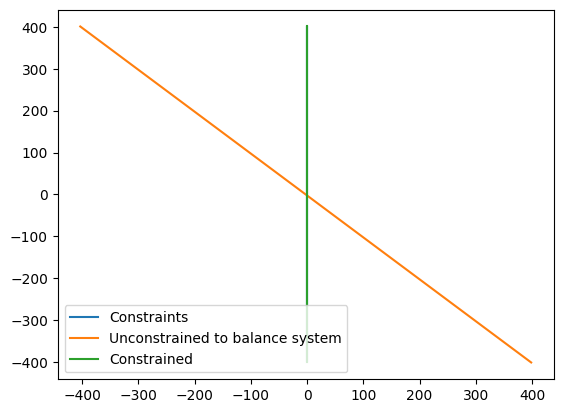

In [220]:
t = 0
i = i_half
solar_min = 0
solar_max = solar_pu[t] * design[0]
discharge_max = design[2] / MWh_per_MW
charge_max = - design[2] / MWh_per_MW
box = np.array([
    [solar_min, discharge_max],
    [solar_max, discharge_max],
    [solar_max, charge_max],
    [solar_min, charge_max],
    [solar_min, discharge_max],
])
battery = sample.U[t, i, :, 1]
solar_unconstrained = w[t] - battery
solar = sample.U[t, i, :, 0]
plt.figure()
plt.plot(box[:, 0], box[:, 1], label="Constraints")
plt.plot(solar_unconstrained, battery, label="Unconstrained to balance system")
plt.plot(solar, battery, label="Constrained")
plt.legend()
# batterysample.U[t, i_half, 1]

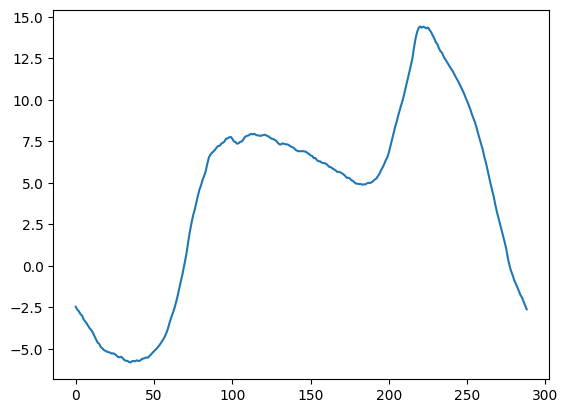

In [223]:
plt.figure()
plt.plot(w)

In [225]:
sample.X.shape

(480,)

In [222]:
sample.X[1] - sample.X[0]

3.3402922755741127

In [224]:
sample.U[0, i_half, 1, 1] - sample.U[0, i_half, 0, 1]

40.08350730688932

In [221]:
u_battery[0]

array([-400.83507307, -360.75156576, -320.66805846, -280.58455115,
       -240.50104384, -200.41753653, -160.33402923, -120.25052192,
        -80.16701461,  -40.08350731,    0.        ,   40.08350731,
         80.16701461,  120.25052192,  160.33402923,  200.41753653,
        240.50104384,  280.58455115,  320.66805846,  360.75156576,
        400.83507307])

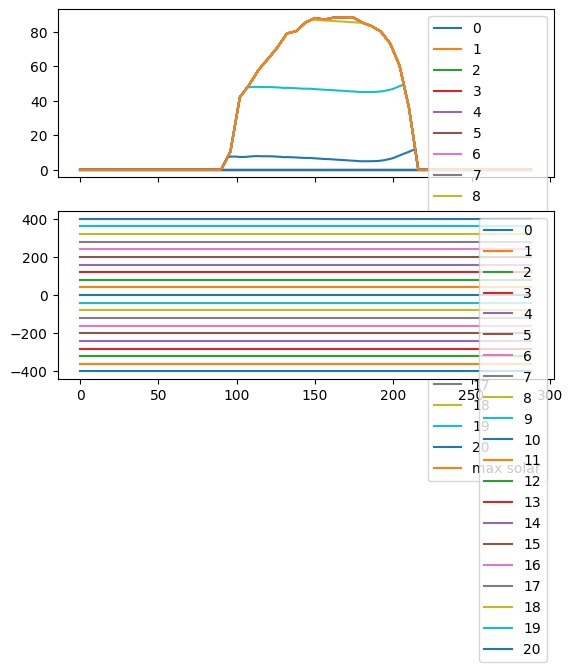

In [215]:
u_solar = sample.U[:, i_half, :, 0]
u_battery = sample.U[:, i_half, :, 1]
_, plots = plt.subplots(2, 1, sharex=True)
labels = [f"{i}" for i in range(u_solar.shape[1])]
plots[0].plot(u_solar, label=labels)
plots[0].plot(solar_pu * design[0], label='max solar')
plots[1].plot(u_battery, label=labels)
for plot in plots:
    plot.legend()


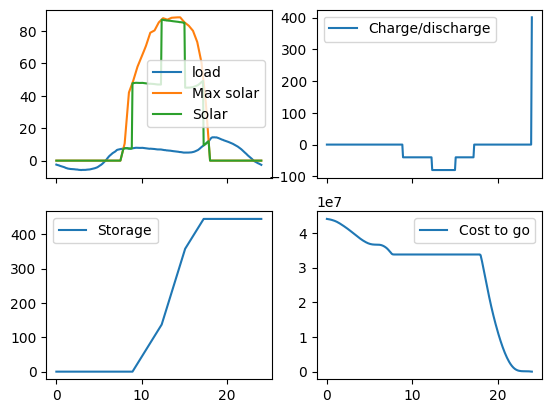

In [217]:
t_hr = load_t / 60
_, plots = plt.subplots(2, 2, sharex=True)
plots = [p for row in plots for p in row]
plots[0].plot(t_hr, w, label='load')
plots[0].plot(t_hr, solar_pu * design[0], label='Max solar')
plots[0].plot(t_hr, u_opt[:, 0], label='Solar')
plots[1].plot(t_hr, u_opt[:, 1], label='Charge/discharge')
plots[2].plot(t_hr, x_opt, label='Storage')
plots[3].plot(t_hr, J_opt, label='Cost to go')
for plot in plots:
    plot.legend()

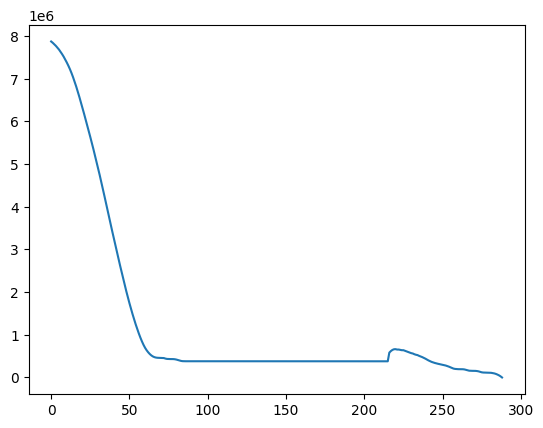

In [80]:
plt.figure()
plt.plot(J[:, 0])

In [ ]:
J[:, -1]

In [ ]:
plt.figure()
plt.plot(u_star)

In [ ]:
plt.plot(u_star)

In [ ]:
def simulate_system(x0, u):
    """
    Simulate system for a given control u and starting state x0.
    
    Arguments:
        x0 (float): initial battery charge
        u (R^(T x U)): control vector at each time T
        
    Returns:
        x (R^T): State at each time [0, T)
    """
    x = np.full(u.shape[0], np.nan)
    x[0] = x0
    for i in range(u.shape[0] - 1):
        x[i + 1] = x[i] + u[i, 1]
    return x

In [ ]:
np.array([1, 2, 3])**2

In [ ]:
def operational_costs(design, w, c_load_lost):
    u = optimal_control(...)
    return 1/2 * c_load_lost * np.sum((np.sum(u, axis=1) - w)**2)

In [ ]:
plt.figure()
plt.plot(load_t, load['power'])

In [ ]:
list(load.keys())

In [ ]:
dni['time']